# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

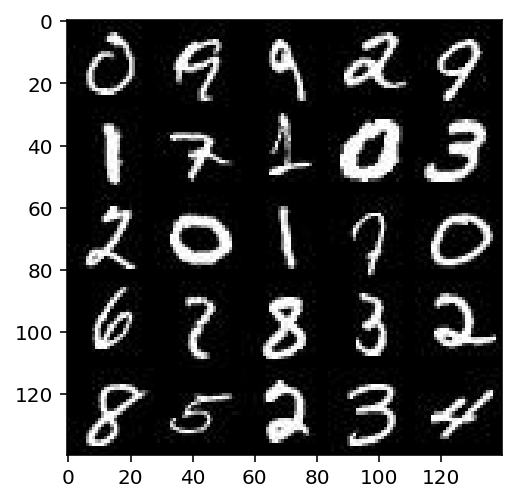

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

In [4]:
mnist_images.shape

(25, 28, 28, 1)

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

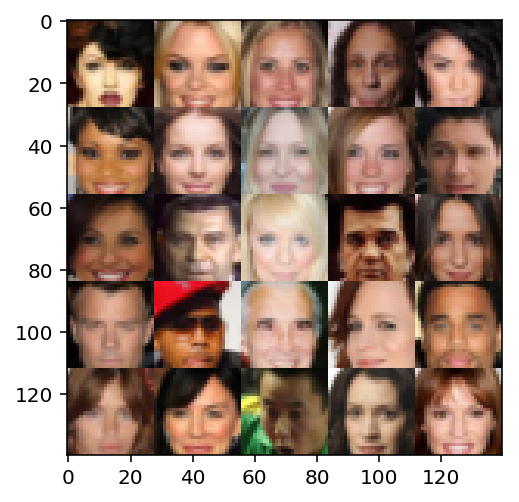

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width,image_height,image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32,name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # print(images.shape)
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope("discriminator",reuse=reuse):
        # input images has (28, 28, channels)
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # (14, 14, 64)
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
#     print(z.shape) # (?,100)
    alpha=0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits) # range [-1,1]
#         print(out.shape)(28, 28, 5)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z,out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    _, image_width, image_height, image_channels = data_shape    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    
    saver = tf.train.Saver()
    steps = 0
    losses = []
    
    print_every = 10
    show_every = 100
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # image valus range from -0.5 to 0.5 of 28x28 dimensional images
                batch_images *= 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr:learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z,})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    # show samples
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
        saver.save(sess, './generator.ckpt')           
    return losses    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0779... Generator Loss: 3.8498
Epoch 1/2... Discriminator Loss: 0.0440... Generator Loss: 4.4507
Epoch 1/2... Discriminator Loss: 0.1946... Generator Loss: 2.5652
Epoch 1/2... Discriminator Loss: 0.0915... Generator Loss: 2.9027
Epoch 1/2... Discriminator Loss: 0.0490... Generator Loss: 3.8886
Epoch 1/2... Discriminator Loss: 0.0336... Generator Loss: 3.9637
Epoch 1/2... Discriminator Loss: 0.0058... Generator Loss: 10.1335
Epoch 1/2... Discriminator Loss: 0.3420... Generator Loss: 1.9803
Epoch 1/2... Discriminator Loss: 3.3397... Generator Loss: 0.1196
Epoch 1/2... Discriminator Loss: 1.8491... Generator Loss: 0.5813


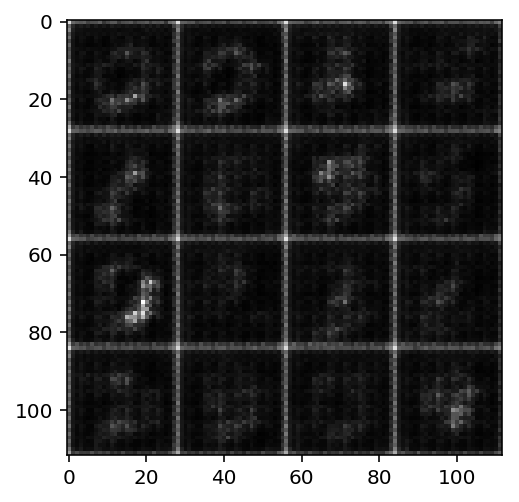

Epoch 1/2... Discriminator Loss: 1.7168... Generator Loss: 0.3886
Epoch 1/2... Discriminator Loss: 1.2992... Generator Loss: 0.7497
Epoch 1/2... Discriminator Loss: 1.2186... Generator Loss: 1.1352
Epoch 1/2... Discriminator Loss: 1.0827... Generator Loss: 1.5034
Epoch 1/2... Discriminator Loss: 1.4752... Generator Loss: 0.3849
Epoch 1/2... Discriminator Loss: 1.2901... Generator Loss: 0.5840
Epoch 1/2... Discriminator Loss: 1.2307... Generator Loss: 0.5680
Epoch 1/2... Discriminator Loss: 1.1506... Generator Loss: 0.6540
Epoch 1/2... Discriminator Loss: 1.2354... Generator Loss: 1.4175
Epoch 1/2... Discriminator Loss: 0.9732... Generator Loss: 0.9613


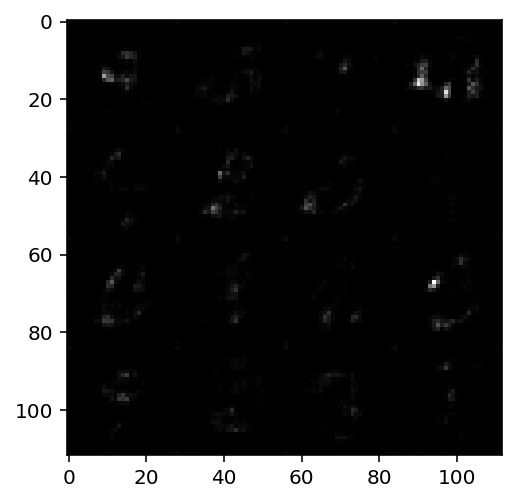

Epoch 1/2... Discriminator Loss: 1.1799... Generator Loss: 1.7760
Epoch 1/2... Discriminator Loss: 0.9970... Generator Loss: 0.9229
Epoch 1/2... Discriminator Loss: 1.0709... Generator Loss: 1.1962
Epoch 1/2... Discriminator Loss: 1.2058... Generator Loss: 1.5259
Epoch 1/2... Discriminator Loss: 0.9245... Generator Loss: 0.8843
Epoch 1/2... Discriminator Loss: 0.9268... Generator Loss: 1.2935
Epoch 1/2... Discriminator Loss: 0.8213... Generator Loss: 1.1961
Epoch 1/2... Discriminator Loss: 0.9553... Generator Loss: 0.7008
Epoch 1/2... Discriminator Loss: 0.8059... Generator Loss: 1.3585
Epoch 1/2... Discriminator Loss: 1.0127... Generator Loss: 0.6919


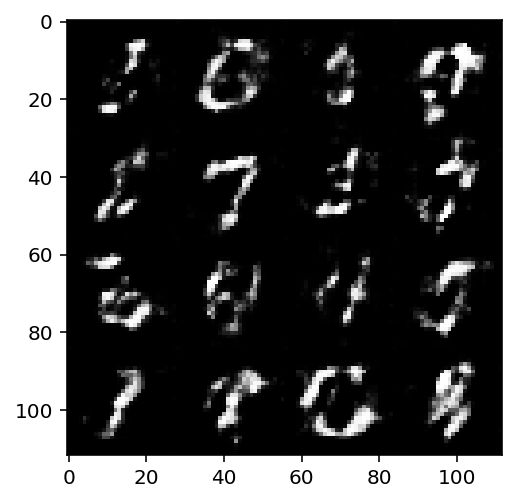

Epoch 1/2... Discriminator Loss: 0.7812... Generator Loss: 1.1595
Epoch 1/2... Discriminator Loss: 0.7258... Generator Loss: 1.2884
Epoch 1/2... Discriminator Loss: 0.9833... Generator Loss: 1.7232
Epoch 1/2... Discriminator Loss: 1.2620... Generator Loss: 0.4616
Epoch 1/2... Discriminator Loss: 0.8903... Generator Loss: 0.7873
Epoch 1/2... Discriminator Loss: 1.0868... Generator Loss: 1.8150
Epoch 1/2... Discriminator Loss: 0.8751... Generator Loss: 1.0762
Epoch 1/2... Discriminator Loss: 0.7887... Generator Loss: 1.3899
Epoch 1/2... Discriminator Loss: 1.1383... Generator Loss: 0.7091
Epoch 1/2... Discriminator Loss: 1.1772... Generator Loss: 0.5381


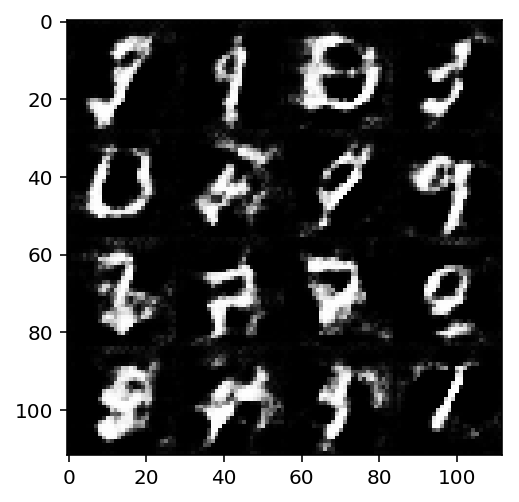

Epoch 1/2... Discriminator Loss: 1.1099... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.1279... Generator Loss: 1.3497
Epoch 1/2... Discriminator Loss: 0.9337... Generator Loss: 1.0233
Epoch 1/2... Discriminator Loss: 1.3691... Generator Loss: 0.4021
Epoch 1/2... Discriminator Loss: 1.0781... Generator Loss: 0.7617
Epoch 1/2... Discriminator Loss: 1.0473... Generator Loss: 1.3750
Epoch 1/2... Discriminator Loss: 0.9825... Generator Loss: 1.5748
Epoch 1/2... Discriminator Loss: 1.0252... Generator Loss: 1.0054
Epoch 1/2... Discriminator Loss: 1.0150... Generator Loss: 0.6633
Epoch 1/2... Discriminator Loss: 1.3089... Generator Loss: 0.4462


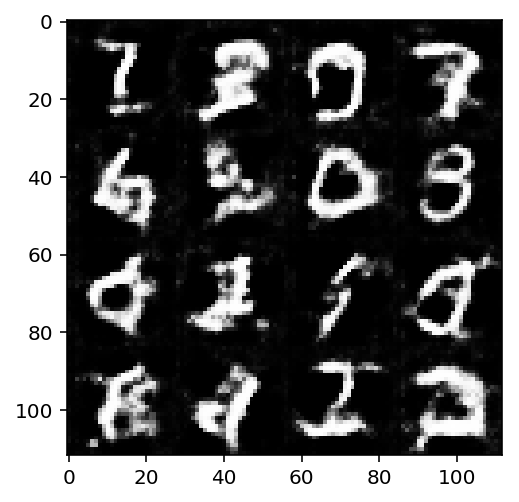

Epoch 1/2... Discriminator Loss: 1.3496... Generator Loss: 0.4224
Epoch 1/2... Discriminator Loss: 1.0424... Generator Loss: 1.7202
Epoch 1/2... Discriminator Loss: 1.0501... Generator Loss: 0.7651
Epoch 1/2... Discriminator Loss: 0.9446... Generator Loss: 1.0029
Epoch 1/2... Discriminator Loss: 0.9026... Generator Loss: 1.1317
Epoch 1/2... Discriminator Loss: 1.1390... Generator Loss: 1.1456
Epoch 1/2... Discriminator Loss: 1.0692... Generator Loss: 1.5696
Epoch 1/2... Discriminator Loss: 1.1356... Generator Loss: 0.8468
Epoch 1/2... Discriminator Loss: 1.2672... Generator Loss: 0.5432
Epoch 1/2... Discriminator Loss: 1.3149... Generator Loss: 0.4282


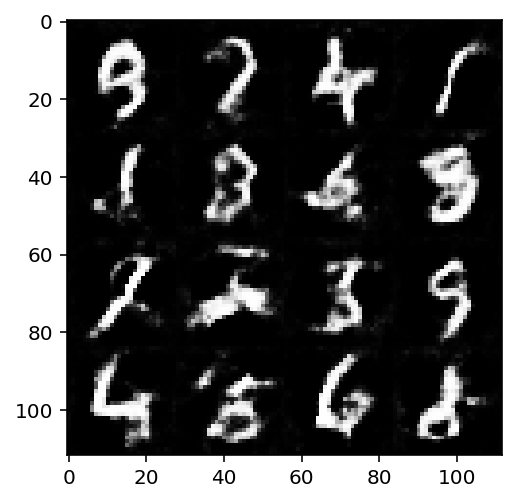

Epoch 1/2... Discriminator Loss: 0.9978... Generator Loss: 1.1114
Epoch 1/2... Discriminator Loss: 1.0042... Generator Loss: 0.8050
Epoch 1/2... Discriminator Loss: 0.9914... Generator Loss: 1.0781
Epoch 1/2... Discriminator Loss: 1.0502... Generator Loss: 0.6471
Epoch 1/2... Discriminator Loss: 1.1623... Generator Loss: 0.6178
Epoch 1/2... Discriminator Loss: 0.9789... Generator Loss: 0.8214
Epoch 1/2... Discriminator Loss: 0.9817... Generator Loss: 0.9373
Epoch 1/2... Discriminator Loss: 1.0882... Generator Loss: 1.1412
Epoch 1/2... Discriminator Loss: 0.9677... Generator Loss: 0.9622
Epoch 1/2... Discriminator Loss: 1.0002... Generator Loss: 0.8725


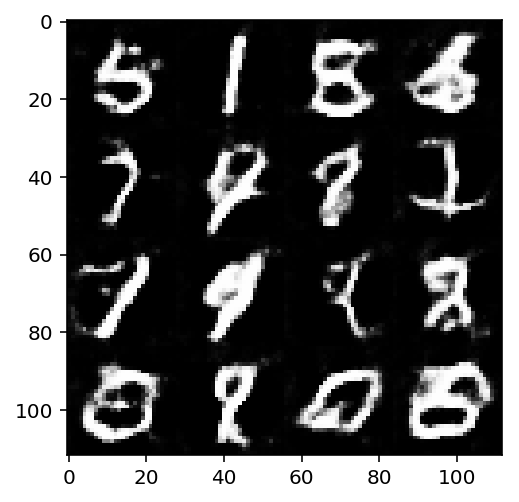

Epoch 1/2... Discriminator Loss: 1.3344... Generator Loss: 0.4381
Epoch 1/2... Discriminator Loss: 1.2330... Generator Loss: 1.6949
Epoch 1/2... Discriminator Loss: 1.0322... Generator Loss: 0.9535
Epoch 1/2... Discriminator Loss: 1.0037... Generator Loss: 0.7825
Epoch 1/2... Discriminator Loss: 0.9927... Generator Loss: 1.0723
Epoch 1/2... Discriminator Loss: 1.0102... Generator Loss: 0.8465
Epoch 1/2... Discriminator Loss: 0.9203... Generator Loss: 1.0643
Epoch 1/2... Discriminator Loss: 1.0613... Generator Loss: 0.6817
Epoch 1/2... Discriminator Loss: 1.0158... Generator Loss: 1.8544
Epoch 1/2... Discriminator Loss: 1.1511... Generator Loss: 0.5558


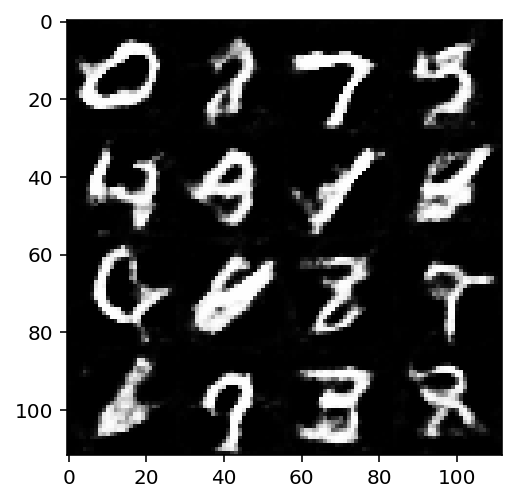

Epoch 1/2... Discriminator Loss: 1.0470... Generator Loss: 0.6781
Epoch 1/2... Discriminator Loss: 1.0237... Generator Loss: 1.3376
Epoch 1/2... Discriminator Loss: 0.9628... Generator Loss: 1.0739
Epoch 1/2... Discriminator Loss: 0.9268... Generator Loss: 1.0109
Epoch 1/2... Discriminator Loss: 1.1315... Generator Loss: 0.6312
Epoch 1/2... Discriminator Loss: 1.3156... Generator Loss: 0.4188
Epoch 1/2... Discriminator Loss: 1.3648... Generator Loss: 0.4028
Epoch 1/2... Discriminator Loss: 0.8453... Generator Loss: 0.9080
Epoch 1/2... Discriminator Loss: 1.1329... Generator Loss: 0.5675
Epoch 1/2... Discriminator Loss: 0.9007... Generator Loss: 1.1200


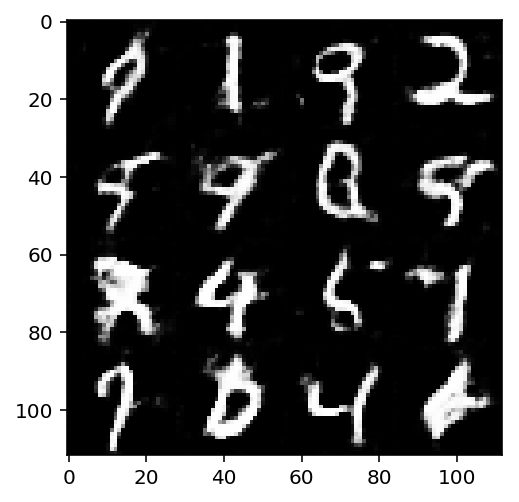

Epoch 1/2... Discriminator Loss: 0.9461... Generator Loss: 1.3088
Epoch 1/2... Discriminator Loss: 0.8542... Generator Loss: 1.1065
Epoch 1/2... Discriminator Loss: 1.0907... Generator Loss: 1.7767
Epoch 2/2... Discriminator Loss: 0.8828... Generator Loss: 0.8703
Epoch 2/2... Discriminator Loss: 1.0453... Generator Loss: 0.8633
Epoch 2/2... Discriminator Loss: 0.8298... Generator Loss: 1.2777
Epoch 2/2... Discriminator Loss: 0.8412... Generator Loss: 1.2717
Epoch 2/2... Discriminator Loss: 1.0105... Generator Loss: 0.7626
Epoch 2/2... Discriminator Loss: 0.9600... Generator Loss: 0.7374
Epoch 2/2... Discriminator Loss: 1.2070... Generator Loss: 0.5664


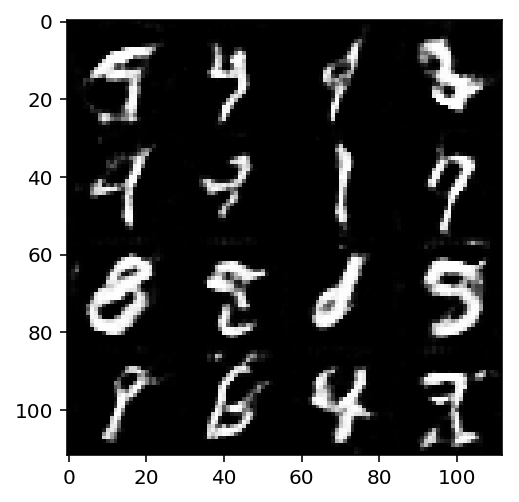

Epoch 2/2... Discriminator Loss: 0.8426... Generator Loss: 0.8770
Epoch 2/2... Discriminator Loss: 1.2257... Generator Loss: 0.4951
Epoch 2/2... Discriminator Loss: 0.8315... Generator Loss: 0.8167
Epoch 2/2... Discriminator Loss: 0.9689... Generator Loss: 0.7292
Epoch 2/2... Discriminator Loss: 1.0865... Generator Loss: 1.0073
Epoch 2/2... Discriminator Loss: 1.1664... Generator Loss: 1.1503
Epoch 2/2... Discriminator Loss: 0.9766... Generator Loss: 0.6706
Epoch 2/2... Discriminator Loss: 1.1435... Generator Loss: 0.5743
Epoch 2/2... Discriminator Loss: 0.8640... Generator Loss: 0.8929
Epoch 2/2... Discriminator Loss: 1.1293... Generator Loss: 0.5467


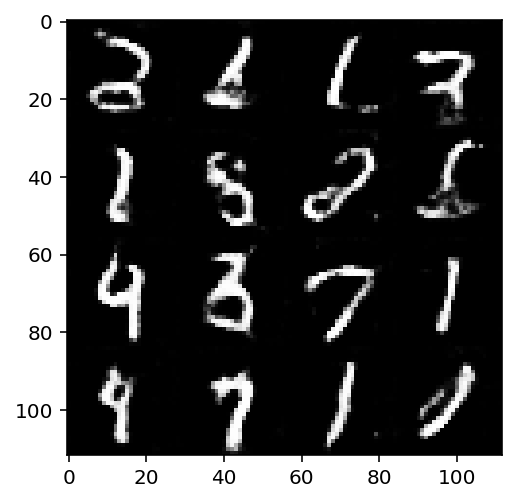

Epoch 2/2... Discriminator Loss: 0.8727... Generator Loss: 0.9699
Epoch 2/2... Discriminator Loss: 0.8879... Generator Loss: 1.6428
Epoch 2/2... Discriminator Loss: 0.8934... Generator Loss: 1.1312
Epoch 2/2... Discriminator Loss: 1.3695... Generator Loss: 0.4052
Epoch 2/2... Discriminator Loss: 0.9558... Generator Loss: 0.7477
Epoch 2/2... Discriminator Loss: 0.8975... Generator Loss: 0.7383
Epoch 2/2... Discriminator Loss: 0.8516... Generator Loss: 1.6998
Epoch 2/2... Discriminator Loss: 2.8985... Generator Loss: 0.0824
Epoch 2/2... Discriminator Loss: 0.9587... Generator Loss: 0.7297
Epoch 2/2... Discriminator Loss: 0.8307... Generator Loss: 0.8785


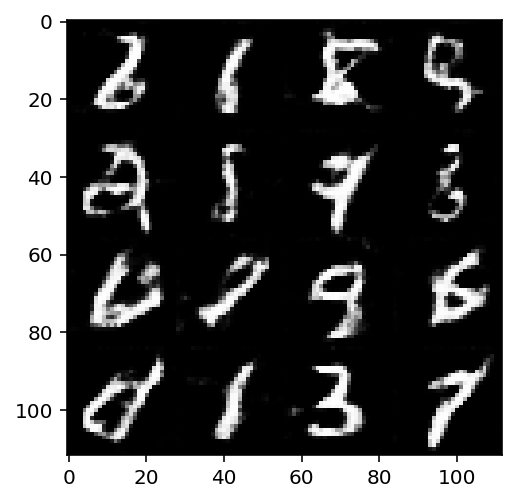

Epoch 2/2... Discriminator Loss: 1.1485... Generator Loss: 0.5279
Epoch 2/2... Discriminator Loss: 1.0056... Generator Loss: 0.6697
Epoch 2/2... Discriminator Loss: 1.6403... Generator Loss: 0.2820
Epoch 2/2... Discriminator Loss: 1.2537... Generator Loss: 0.4287
Epoch 2/2... Discriminator Loss: 1.4256... Generator Loss: 1.1777
Epoch 2/2... Discriminator Loss: 1.1422... Generator Loss: 0.7037
Epoch 2/2... Discriminator Loss: 0.9436... Generator Loss: 0.8665
Epoch 2/2... Discriminator Loss: 0.9606... Generator Loss: 0.8440
Epoch 2/2... Discriminator Loss: 0.9856... Generator Loss: 0.7209
Epoch 2/2... Discriminator Loss: 0.7804... Generator Loss: 1.1145


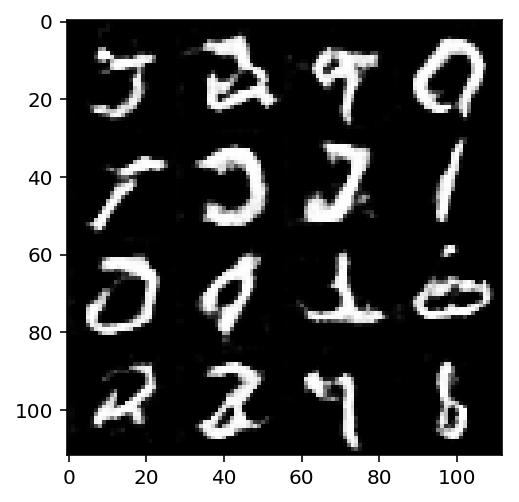

Epoch 2/2... Discriminator Loss: 0.8453... Generator Loss: 0.9712
Epoch 2/2... Discriminator Loss: 0.8797... Generator Loss: 0.8524
Epoch 2/2... Discriminator Loss: 0.7861... Generator Loss: 1.2038
Epoch 2/2... Discriminator Loss: 1.0359... Generator Loss: 0.6465
Epoch 2/2... Discriminator Loss: 1.0088... Generator Loss: 0.6921
Epoch 2/2... Discriminator Loss: 1.3372... Generator Loss: 0.4624
Epoch 2/2... Discriminator Loss: 1.0708... Generator Loss: 0.6692
Epoch 2/2... Discriminator Loss: 1.0176... Generator Loss: 0.6468
Epoch 2/2... Discriminator Loss: 0.8323... Generator Loss: 0.9714
Epoch 2/2... Discriminator Loss: 0.7370... Generator Loss: 0.9785


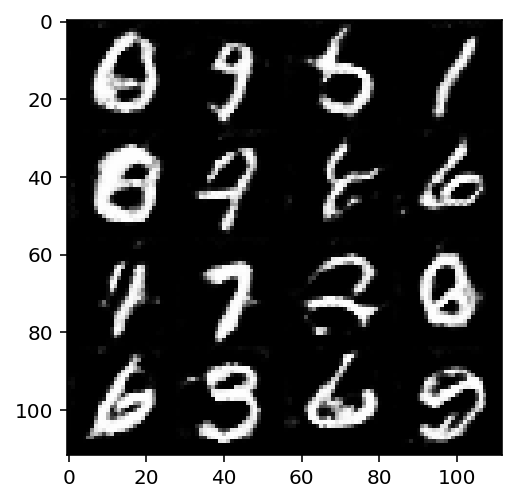

Epoch 2/2... Discriminator Loss: 0.9405... Generator Loss: 0.7004
Epoch 2/2... Discriminator Loss: 1.0685... Generator Loss: 0.6361
Epoch 2/2... Discriminator Loss: 1.0938... Generator Loss: 1.9878
Epoch 2/2... Discriminator Loss: 1.1955... Generator Loss: 0.6088
Epoch 2/2... Discriminator Loss: 0.9865... Generator Loss: 0.7347
Epoch 2/2... Discriminator Loss: 1.0083... Generator Loss: 1.9687
Epoch 2/2... Discriminator Loss: 0.8263... Generator Loss: 1.0124
Epoch 2/2... Discriminator Loss: 0.8062... Generator Loss: 0.9584
Epoch 2/2... Discriminator Loss: 0.7191... Generator Loss: 1.5132
Epoch 2/2... Discriminator Loss: 1.1994... Generator Loss: 0.5057


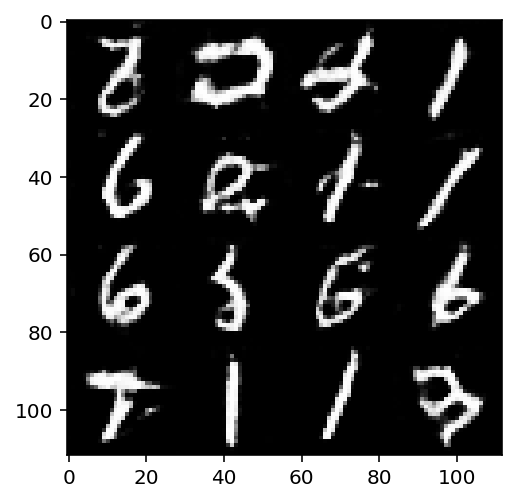

Epoch 2/2... Discriminator Loss: 1.7579... Generator Loss: 0.2921
Epoch 2/2... Discriminator Loss: 1.0034... Generator Loss: 0.8009
Epoch 2/2... Discriminator Loss: 1.2117... Generator Loss: 0.4545
Epoch 2/2... Discriminator Loss: 0.7719... Generator Loss: 1.4354
Epoch 2/2... Discriminator Loss: 0.9012... Generator Loss: 0.7866
Epoch 2/2... Discriminator Loss: 0.8347... Generator Loss: 1.2074
Epoch 2/2... Discriminator Loss: 1.0226... Generator Loss: 1.7422
Epoch 2/2... Discriminator Loss: 0.7973... Generator Loss: 1.3046
Epoch 2/2... Discriminator Loss: 1.3586... Generator Loss: 2.1367
Epoch 2/2... Discriminator Loss: 0.7972... Generator Loss: 1.1262


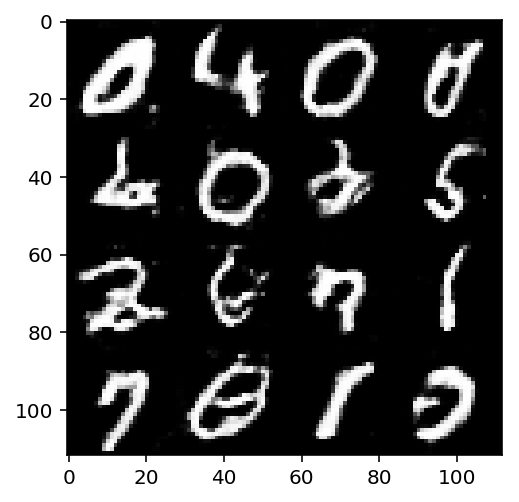

Epoch 2/2... Discriminator Loss: 0.8513... Generator Loss: 0.8031
Epoch 2/2... Discriminator Loss: 0.6705... Generator Loss: 1.4044
Epoch 2/2... Discriminator Loss: 0.7670... Generator Loss: 0.9431
Epoch 2/2... Discriminator Loss: 0.7745... Generator Loss: 1.2143
Epoch 2/2... Discriminator Loss: 1.1149... Generator Loss: 0.5396
Epoch 2/2... Discriminator Loss: 0.7178... Generator Loss: 1.5917
Epoch 2/2... Discriminator Loss: 0.5105... Generator Loss: 1.6572
Epoch 2/2... Discriminator Loss: 1.0195... Generator Loss: 0.6965
Epoch 2/2... Discriminator Loss: 0.7693... Generator Loss: 1.1846
Epoch 2/2... Discriminator Loss: 1.0376... Generator Loss: 0.6681


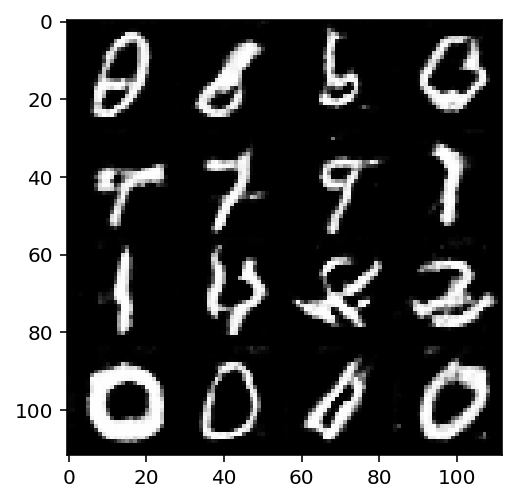

Epoch 2/2... Discriminator Loss: 0.7942... Generator Loss: 0.8350
Epoch 2/2... Discriminator Loss: 0.8890... Generator Loss: 1.7540
Epoch 2/2... Discriminator Loss: 1.5095... Generator Loss: 0.3634
Epoch 2/2... Discriminator Loss: 1.0587... Generator Loss: 1.6972
Epoch 2/2... Discriminator Loss: 0.6499... Generator Loss: 1.4222
Epoch 2/2... Discriminator Loss: 0.9911... Generator Loss: 1.6506
Epoch 2/2... Discriminator Loss: 0.7284... Generator Loss: 1.7643
Epoch 2/2... Discriminator Loss: 0.7913... Generator Loss: 0.9882
Epoch 2/2... Discriminator Loss: 1.1919... Generator Loss: 0.5155
Epoch 2/2... Discriminator Loss: 0.8058... Generator Loss: 0.9377


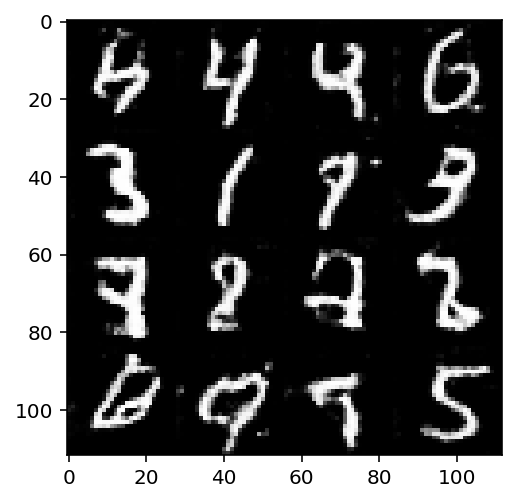

Epoch 2/2... Discriminator Loss: 0.8074... Generator Loss: 1.0753
Epoch 2/2... Discriminator Loss: 1.1516... Generator Loss: 0.5423
Epoch 2/2... Discriminator Loss: 0.9597... Generator Loss: 1.5835
Epoch 2/2... Discriminator Loss: 0.8755... Generator Loss: 0.9941
Epoch 2/2... Discriminator Loss: 1.0006... Generator Loss: 0.6921
Epoch 2/2... Discriminator Loss: 0.8948... Generator Loss: 0.7418
Epoch 2/2... Discriminator Loss: 1.4364... Generator Loss: 2.1974


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.1046... Generator Loss: 3.0336
Epoch 1/1... Discriminator Loss: 0.0170... Generator Loss: 5.2825
Epoch 1/1... Discriminator Loss: 1.8197... Generator Loss: 0.5135
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 3.8877
Epoch 1/1... Discriminator Loss: 0.7960... Generator Loss: 0.9121
Epoch 1/1... Discriminator Loss: 0.5860... Generator Loss: 1.7192
Epoch 1/1... Discriminator Loss: 0.3433... Generator Loss: 2.4582
Epoch 1/1... Discriminator Loss: 0.4059... Generator Loss: 1.9486
Epoch 1/1... Discriminator Loss: 0.2267... Generator Loss: 2.3613
Epoch 1/1... Discriminator Loss: 2.9444... Generator Loss: 0.1922


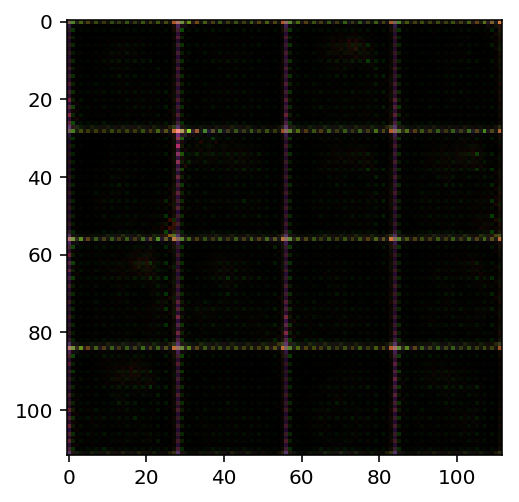

Epoch 1/1... Discriminator Loss: 0.5082... Generator Loss: 7.7601
Epoch 1/1... Discriminator Loss: 0.5676... Generator Loss: 1.1513
Epoch 1/1... Discriminator Loss: 0.8327... Generator Loss: 0.9561
Epoch 1/1... Discriminator Loss: 0.5259... Generator Loss: 1.4662
Epoch 1/1... Discriminator Loss: 0.7609... Generator Loss: 1.8793
Epoch 1/1... Discriminator Loss: 0.9368... Generator Loss: 1.4321
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 1.1505
Epoch 1/1... Discriminator Loss: 1.9287... Generator Loss: 4.4499
Epoch 1/1... Discriminator Loss: 2.0591... Generator Loss: 1.7829
Epoch 1/1... Discriminator Loss: 0.5937... Generator Loss: 2.0364


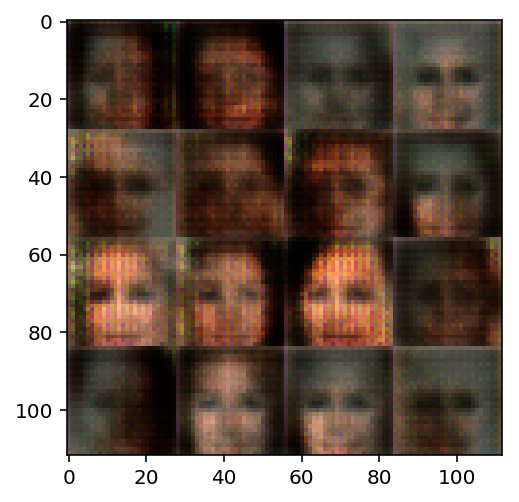

Epoch 1/1... Discriminator Loss: 0.9704... Generator Loss: 1.6303
Epoch 1/1... Discriminator Loss: 0.9835... Generator Loss: 1.3820
Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.0157... Generator Loss: 1.1850
Epoch 1/1... Discriminator Loss: 3.0172... Generator Loss: 0.0855
Epoch 1/1... Discriminator Loss: 1.2981... Generator Loss: 2.5342
Epoch 1/1... Discriminator Loss: 0.9004... Generator Loss: 1.4213
Epoch 1/1... Discriminator Loss: 1.0203... Generator Loss: 4.0968
Epoch 1/1... Discriminator Loss: 1.6197... Generator Loss: 1.9989
Epoch 1/1... Discriminator Loss: 1.0896... Generator Loss: 0.8011


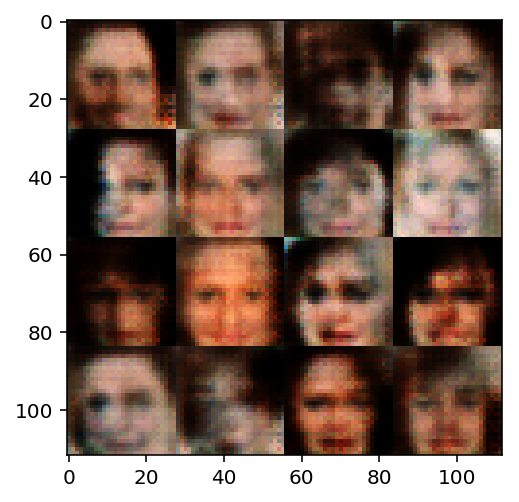

Epoch 1/1... Discriminator Loss: 0.7273... Generator Loss: 1.2607
Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 1.0955
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 1.1721
Epoch 1/1... Discriminator Loss: 1.5976... Generator Loss: 3.5798
Epoch 1/1... Discriminator Loss: 1.3030... Generator Loss: 1.1471
Epoch 1/1... Discriminator Loss: 1.0679... Generator Loss: 0.8858
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.3879
Epoch 1/1... Discriminator Loss: 0.9549... Generator Loss: 1.1010
Epoch 1/1... Discriminator Loss: 1.2961... Generator Loss: 0.5049
Epoch 1/1... Discriminator Loss: 1.0679... Generator Loss: 1.1638


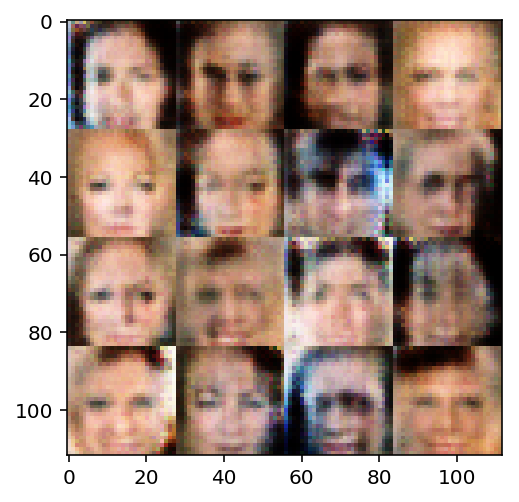

Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 0.9305
Epoch 1/1... Discriminator Loss: 0.8336... Generator Loss: 1.4025
Epoch 1/1... Discriminator Loss: 1.1497... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.0273... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 0.7667... Generator Loss: 2.0655
Epoch 1/1... Discriminator Loss: 0.9947... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 1.7163... Generator Loss: 0.2905
Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 0.9238... Generator Loss: 0.9996
Epoch 1/1... Discriminator Loss: 2.1091... Generator Loss: 0.1835


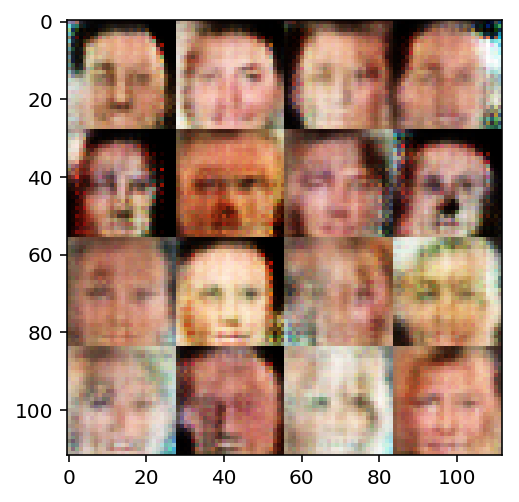

Epoch 1/1... Discriminator Loss: 1.1949... Generator Loss: 0.5655
Epoch 1/1... Discriminator Loss: 0.8571... Generator Loss: 2.0685
Epoch 1/1... Discriminator Loss: 0.9629... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 0.7870... Generator Loss: 1.2715
Epoch 1/1... Discriminator Loss: 1.2953... Generator Loss: 0.5576
Epoch 1/1... Discriminator Loss: 0.6420... Generator Loss: 1.7079
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 1.4794... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 0.7652... Generator Loss: 2.5599


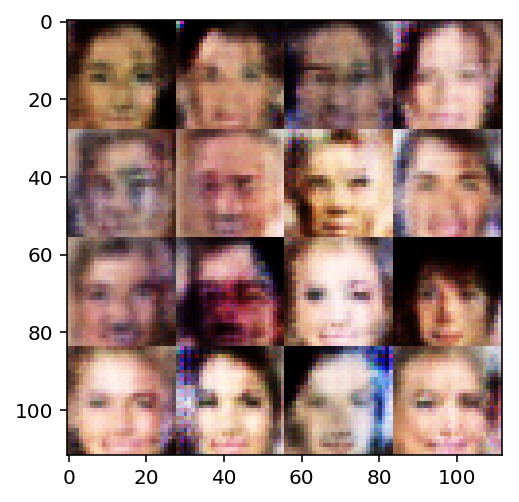

Epoch 1/1... Discriminator Loss: 0.9166... Generator Loss: 3.0304
Epoch 1/1... Discriminator Loss: 0.7988... Generator Loss: 1.1244
Epoch 1/1... Discriminator Loss: 2.1006... Generator Loss: 2.2864
Epoch 1/1... Discriminator Loss: 1.7029... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 0.5876
Epoch 1/1... Discriminator Loss: 1.0372... Generator Loss: 0.9326
Epoch 1/1... Discriminator Loss: 1.6842... Generator Loss: 0.2674
Epoch 1/1... Discriminator Loss: 2.0982... Generator Loss: 0.1793
Epoch 1/1... Discriminator Loss: 1.2703... Generator Loss: 0.7005
Epoch 1/1... Discriminator Loss: 0.6815... Generator Loss: 1.3598


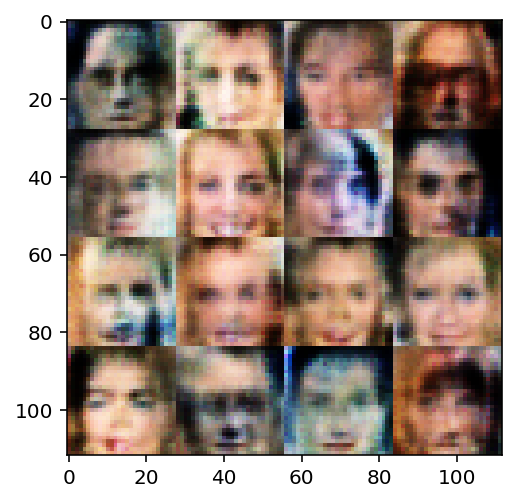

Epoch 1/1... Discriminator Loss: 0.9892... Generator Loss: 2.6589
Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.5946
Epoch 1/1... Discriminator Loss: 1.1845... Generator Loss: 2.2559
Epoch 1/1... Discriminator Loss: 1.0766... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.0663... Generator Loss: 0.8927
Epoch 1/1... Discriminator Loss: 0.6876... Generator Loss: 1.1949
Epoch 1/1... Discriminator Loss: 1.0325... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 0.6185... Generator Loss: 1.8191
Epoch 1/1... Discriminator Loss: 1.2965... Generator Loss: 0.4929


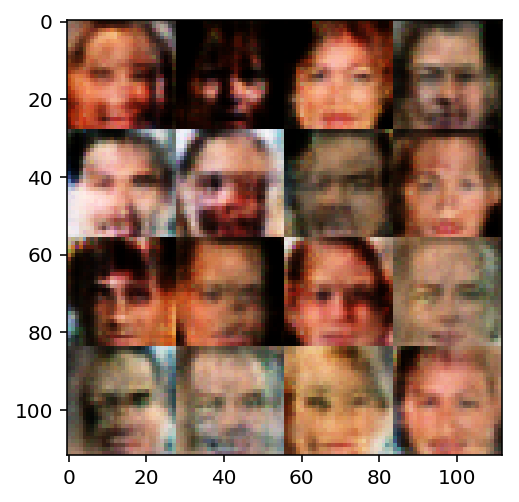

Epoch 1/1... Discriminator Loss: 0.6795... Generator Loss: 1.0671
Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 1.0773
Epoch 1/1... Discriminator Loss: 1.0779... Generator Loss: 1.2886
Epoch 1/1... Discriminator Loss: 1.1407... Generator Loss: 0.8471
Epoch 1/1... Discriminator Loss: 1.1049... Generator Loss: 0.6328
Epoch 1/1... Discriminator Loss: 0.8179... Generator Loss: 1.9555
Epoch 1/1... Discriminator Loss: 0.9388... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 1.1682... Generator Loss: 1.3387
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 2.2203
Epoch 1/1... Discriminator Loss: 1.9906... Generator Loss: 1.8341


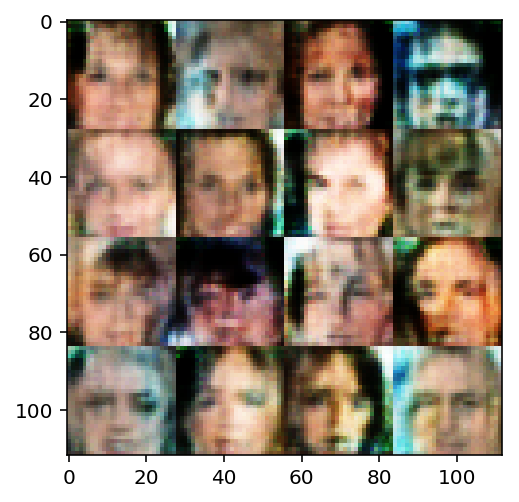

Epoch 1/1... Discriminator Loss: 0.6333... Generator Loss: 1.4213
Epoch 1/1... Discriminator Loss: 1.1075... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 0.8081... Generator Loss: 1.2510
Epoch 1/1... Discriminator Loss: 0.9537... Generator Loss: 0.9391
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.4067
Epoch 1/1... Discriminator Loss: 0.9457... Generator Loss: 0.6316
Epoch 1/1... Discriminator Loss: 1.0871... Generator Loss: 0.9256
Epoch 1/1... Discriminator Loss: 0.5710... Generator Loss: 2.5712
Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 1.0647... Generator Loss: 0.9279


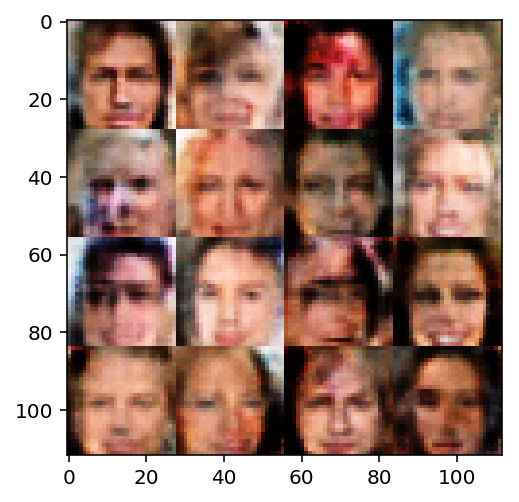

Epoch 1/1... Discriminator Loss: 1.1327... Generator Loss: 0.8792
Epoch 1/1... Discriminator Loss: 1.2825... Generator Loss: 0.5659
Epoch 1/1... Discriminator Loss: 1.2112... Generator Loss: 0.5544
Epoch 1/1... Discriminator Loss: 1.8910... Generator Loss: 0.1867
Epoch 1/1... Discriminator Loss: 0.9645... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.5233... Generator Loss: 1.5748
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.4245
Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 0.5771
Epoch 1/1... Discriminator Loss: 1.0773... Generator Loss: 0.5738
Epoch 1/1... Discriminator Loss: 1.2741... Generator Loss: 1.0688


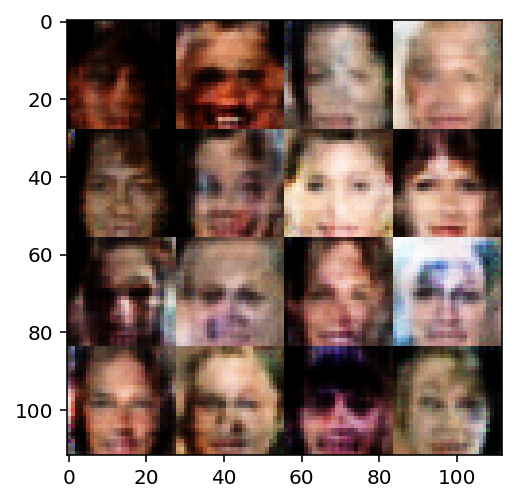

Epoch 1/1... Discriminator Loss: 0.9680... Generator Loss: 0.6314
Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 0.5693
Epoch 1/1... Discriminator Loss: 0.7275... Generator Loss: 1.8165
Epoch 1/1... Discriminator Loss: 1.1494... Generator Loss: 0.6195
Epoch 1/1... Discriminator Loss: 1.1109... Generator Loss: 0.5678
Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 0.4748
Epoch 1/1... Discriminator Loss: 1.2283... Generator Loss: 3.5185
Epoch 1/1... Discriminator Loss: 0.5467... Generator Loss: 1.3600
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 0.5567... Generator Loss: 1.2896


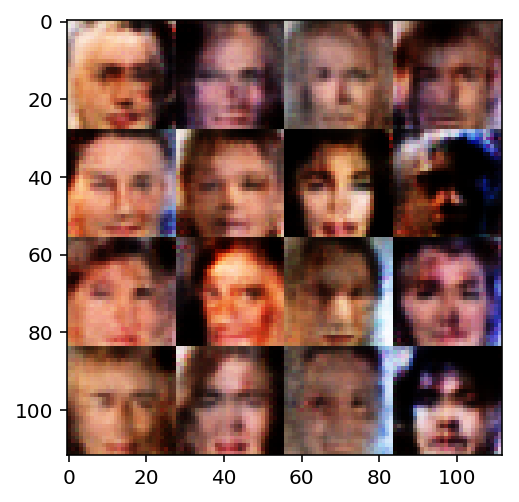

Epoch 1/1... Discriminator Loss: 1.0936... Generator Loss: 0.5199
Epoch 1/1... Discriminator Loss: 1.1302... Generator Loss: 1.2244
Epoch 1/1... Discriminator Loss: 1.1731... Generator Loss: 0.6329
Epoch 1/1... Discriminator Loss: 0.9848... Generator Loss: 0.6159
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 1.4396
Epoch 1/1... Discriminator Loss: 0.5885... Generator Loss: 1.6932
Epoch 1/1... Discriminator Loss: 1.3147... Generator Loss: 0.4744
Epoch 1/1... Discriminator Loss: 1.0676... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 0.6645... Generator Loss: 1.1600
Epoch 1/1... Discriminator Loss: 0.4610... Generator Loss: 1.5387


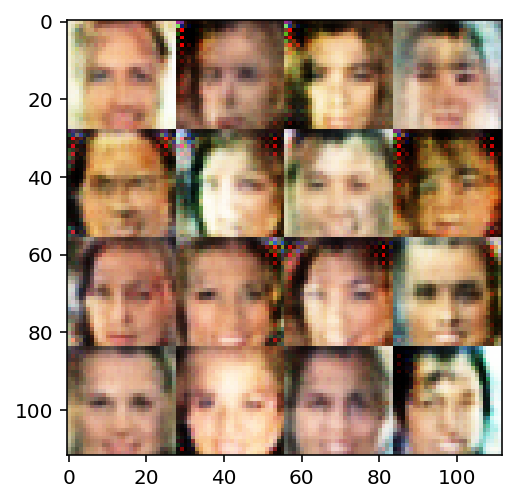

Epoch 1/1... Discriminator Loss: 0.8951... Generator Loss: 1.1209
Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 1.9735
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.4755
Epoch 1/1... Discriminator Loss: 0.8727... Generator Loss: 1.0070
Epoch 1/1... Discriminator Loss: 0.7333... Generator Loss: 1.0173
Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 0.5454
Epoch 1/1... Discriminator Loss: 0.8058... Generator Loss: 0.8693
Epoch 1/1... Discriminator Loss: 1.5326... Generator Loss: 0.2717
Epoch 1/1... Discriminator Loss: 0.6051... Generator Loss: 1.5618
Epoch 1/1... Discriminator Loss: 1.0494... Generator Loss: 0.6883


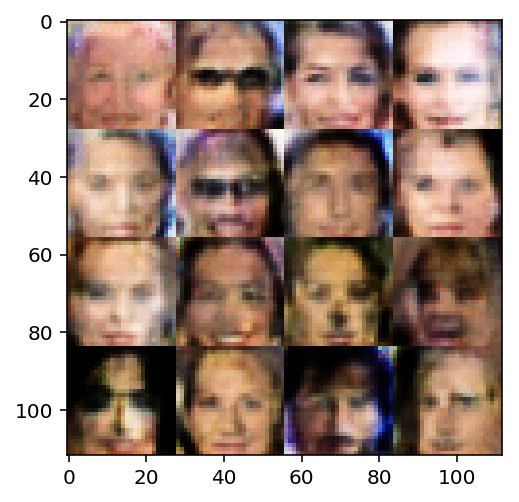

Epoch 1/1... Discriminator Loss: 1.5886... Generator Loss: 0.6001
Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 1.1748
Epoch 1/1... Discriminator Loss: 1.6995... Generator Loss: 0.2955
Epoch 1/1... Discriminator Loss: 0.5779... Generator Loss: 2.2816
Epoch 1/1... Discriminator Loss: 1.0694... Generator Loss: 0.8566
Epoch 1/1... Discriminator Loss: 1.1205... Generator Loss: 1.3332
Epoch 1/1... Discriminator Loss: 1.7361... Generator Loss: 2.2676
Epoch 1/1... Discriminator Loss: 0.8026... Generator Loss: 1.5185


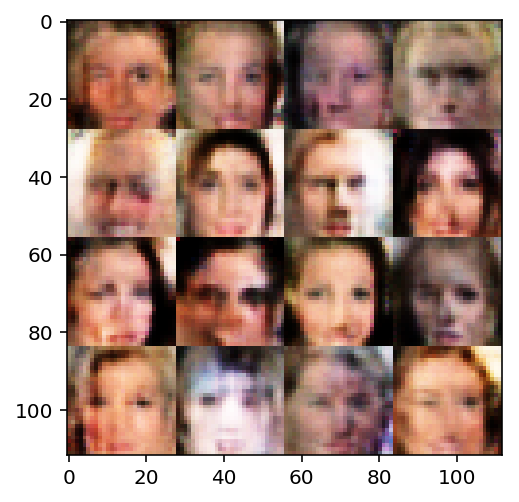

Epoch 1/1... Discriminator Loss: 1.0031... Generator Loss: 0.9343
Epoch 1/1... Discriminator Loss: 0.9579... Generator Loss: 1.1641
Epoch 1/1... Discriminator Loss: 1.0284... Generator Loss: 2.1315
Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 1.2337
Epoch 1/1... Discriminator Loss: 0.6614... Generator Loss: 1.7542
Epoch 1/1... Discriminator Loss: 0.6177... Generator Loss: 1.3790
Epoch 1/1... Discriminator Loss: 0.6658... Generator Loss: 0.9049
Epoch 1/1... Discriminator Loss: 1.4774... Generator Loss: 0.4278
Epoch 1/1... Discriminator Loss: 1.2116... Generator Loss: 1.2184
Epoch 1/1... Discriminator Loss: 0.8024... Generator Loss: 0.9047


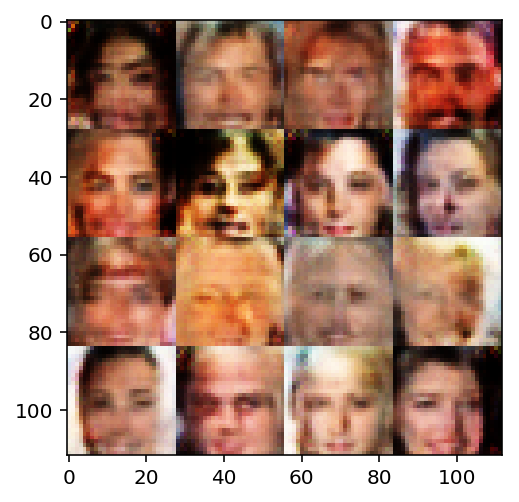

Epoch 1/1... Discriminator Loss: 0.9770... Generator Loss: 0.8732
Epoch 1/1... Discriminator Loss: 0.7588... Generator Loss: 0.9372
Epoch 1/1... Discriminator Loss: 1.0262... Generator Loss: 1.0579
Epoch 1/1... Discriminator Loss: 0.7150... Generator Loss: 1.2457
Epoch 1/1... Discriminator Loss: 0.7688... Generator Loss: 0.9264
Epoch 1/1... Discriminator Loss: 0.8534... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 0.9646... Generator Loss: 0.7400
Epoch 1/1... Discriminator Loss: 1.5154... Generator Loss: 1.4692
Epoch 1/1... Discriminator Loss: 0.5419... Generator Loss: 1.5841
Epoch 1/1... Discriminator Loss: 0.5521... Generator Loss: 1.1599


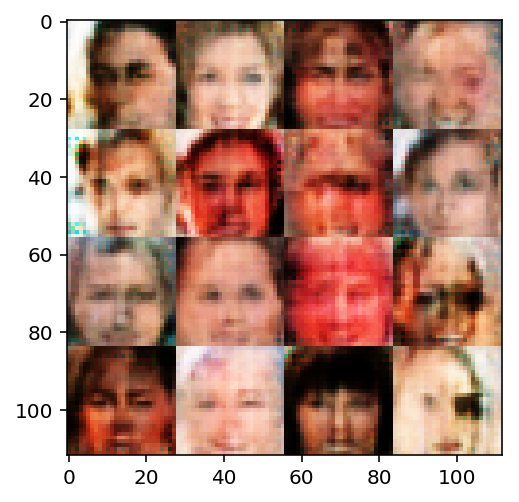

Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.3650
Epoch 1/1... Discriminator Loss: 1.0002... Generator Loss: 1.0259
Epoch 1/1... Discriminator Loss: 1.2477... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 1.0332... Generator Loss: 1.4066
Epoch 1/1... Discriminator Loss: 0.7833... Generator Loss: 0.8714
Epoch 1/1... Discriminator Loss: 0.9865... Generator Loss: 1.4936
Epoch 1/1... Discriminator Loss: 1.1345... Generator Loss: 1.0796
Epoch 1/1... Discriminator Loss: 1.5995... Generator Loss: 0.3459
Epoch 1/1... Discriminator Loss: 1.1076... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 0.9588... Generator Loss: 1.2569


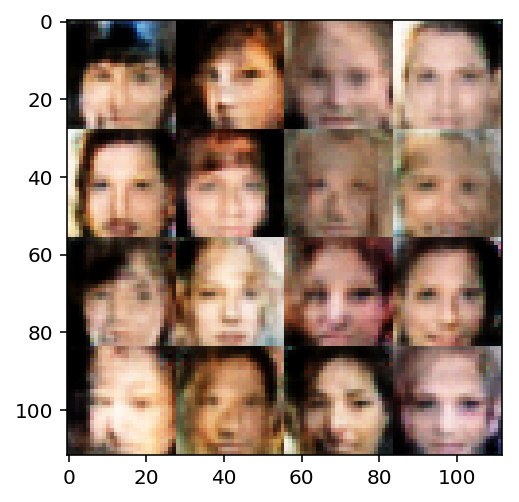

Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.4131
Epoch 1/1... Discriminator Loss: 1.0674... Generator Loss: 0.6114
Epoch 1/1... Discriminator Loss: 0.5159... Generator Loss: 1.6845
Epoch 1/1... Discriminator Loss: 0.7990... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.0442... Generator Loss: 0.7716
Epoch 1/1... Discriminator Loss: 1.1319... Generator Loss: 1.9194
Epoch 1/1... Discriminator Loss: 0.6500... Generator Loss: 1.1624
Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 1.4499
Epoch 1/1... Discriminator Loss: 1.4718... Generator Loss: 0.4028
Epoch 1/1... Discriminator Loss: 0.9991... Generator Loss: 0.8849


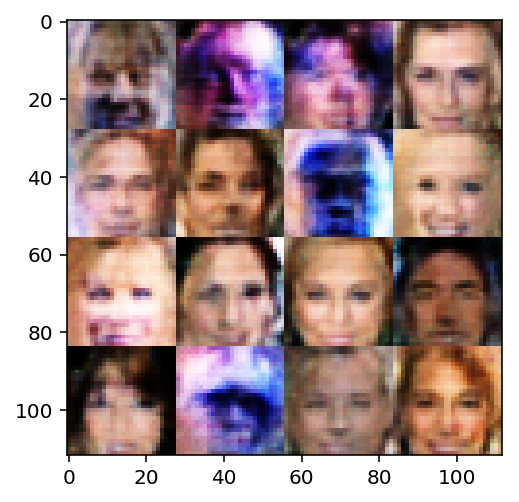

Epoch 1/1... Discriminator Loss: 1.0258... Generator Loss: 0.6064
Epoch 1/1... Discriminator Loss: 0.6931... Generator Loss: 1.3294
Epoch 1/1... Discriminator Loss: 0.5411... Generator Loss: 2.1940
Epoch 1/1... Discriminator Loss: 1.5060... Generator Loss: 0.2981
Epoch 1/1... Discriminator Loss: 1.2534... Generator Loss: 0.5841
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.4218
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.4290
Epoch 1/1... Discriminator Loss: 0.9894... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 0.9008... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 0.7338... Generator Loss: 0.8240


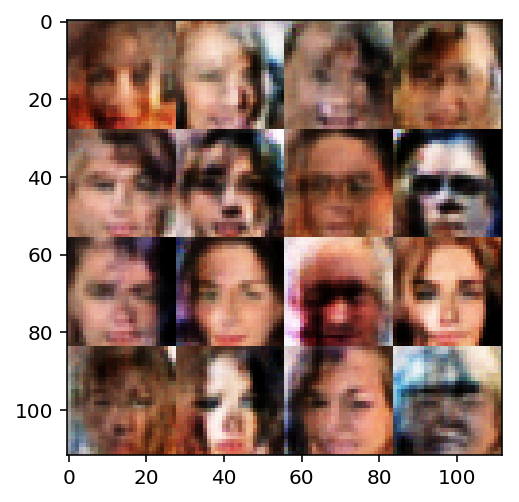

Epoch 1/1... Discriminator Loss: 0.3235... Generator Loss: 2.0412
Epoch 1/1... Discriminator Loss: 0.8216... Generator Loss: 1.7456
Epoch 1/1... Discriminator Loss: 0.4229... Generator Loss: 1.6062
Epoch 1/1... Discriminator Loss: 1.5829... Generator Loss: 0.4263
Epoch 1/1... Discriminator Loss: 0.7104... Generator Loss: 1.1225
Epoch 1/1... Discriminator Loss: 0.5683... Generator Loss: 2.5714
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.3916
Epoch 1/1... Discriminator Loss: 1.2691... Generator Loss: 1.5179
Epoch 1/1... Discriminator Loss: 1.0632... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 0.3100... Generator Loss: 2.9029


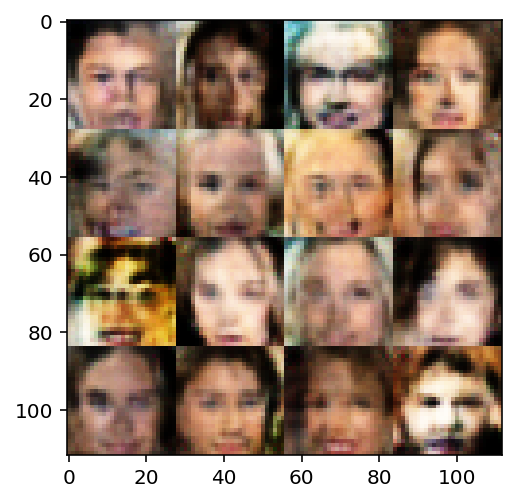

Epoch 1/1... Discriminator Loss: 0.5954... Generator Loss: 2.0369
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 2.8613
Epoch 1/1... Discriminator Loss: 0.7608... Generator Loss: 1.1868
Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 1.4836
Epoch 1/1... Discriminator Loss: 0.9354... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.0040... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 0.7014... Generator Loss: 2.2705
Epoch 1/1... Discriminator Loss: 1.8086... Generator Loss: 0.2910
Epoch 1/1... Discriminator Loss: 0.5153... Generator Loss: 1.7866
Epoch 1/1... Discriminator Loss: 0.8382... Generator Loss: 1.7735


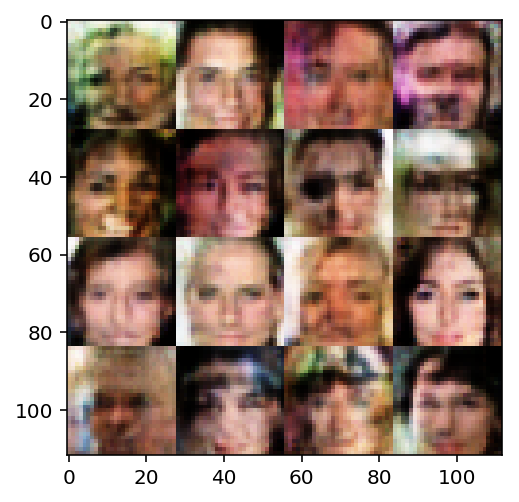

Epoch 1/1... Discriminator Loss: 0.7321... Generator Loss: 2.8382
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.4131
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.5578
Epoch 1/1... Discriminator Loss: 0.5775... Generator Loss: 1.5021
Epoch 1/1... Discriminator Loss: 0.8014... Generator Loss: 1.1033
Epoch 1/1... Discriminator Loss: 1.2351... Generator Loss: 0.5422
Epoch 1/1... Discriminator Loss: 0.6992... Generator Loss: 1.5717
Epoch 1/1... Discriminator Loss: 0.8472... Generator Loss: 1.5289
Epoch 1/1... Discriminator Loss: 0.5925... Generator Loss: 1.1928
Epoch 1/1... Discriminator Loss: 0.6322... Generator Loss: 1.9009


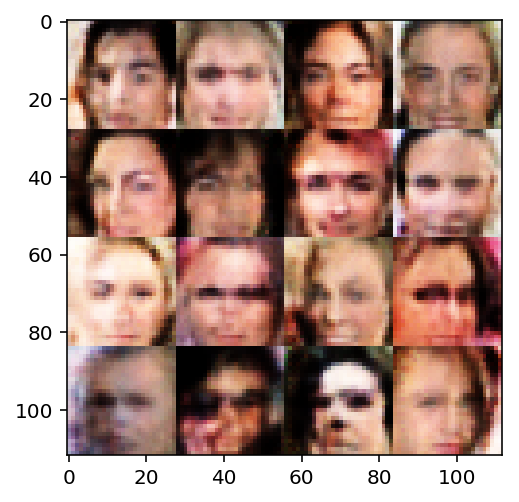

Epoch 1/1... Discriminator Loss: 0.7554... Generator Loss: 2.1011
Epoch 1/1... Discriminator Loss: 0.8326... Generator Loss: 1.3247
Epoch 1/1... Discriminator Loss: 0.6194... Generator Loss: 1.5558
Epoch 1/1... Discriminator Loss: 0.9506... Generator Loss: 0.8848
Epoch 1/1... Discriminator Loss: 0.5545... Generator Loss: 3.4825
Epoch 1/1... Discriminator Loss: 1.9726... Generator Loss: 2.7209
Epoch 1/1... Discriminator Loss: 1.6529... Generator Loss: 0.2800
Epoch 1/1... Discriminator Loss: 0.6611... Generator Loss: 1.3323
Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 0.5366
Epoch 1/1... Discriminator Loss: 1.1321... Generator Loss: 0.8389


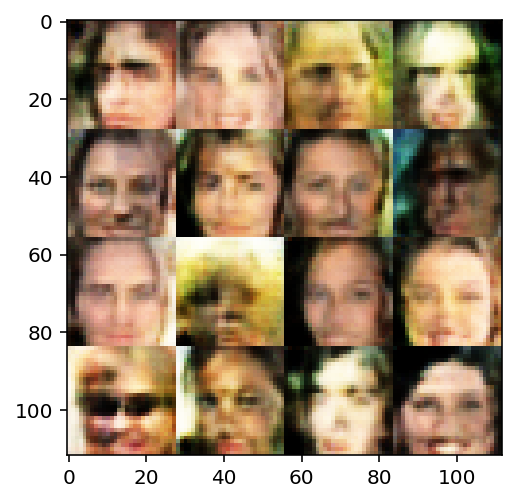

Epoch 1/1... Discriminator Loss: 1.6299... Generator Loss: 0.3251
Epoch 1/1... Discriminator Loss: 0.9124... Generator Loss: 0.9034
Epoch 1/1... Discriminator Loss: 0.5748... Generator Loss: 1.4744
Epoch 1/1... Discriminator Loss: 0.5079... Generator Loss: 1.7292
Epoch 1/1... Discriminator Loss: 0.5767... Generator Loss: 1.2868
Epoch 1/1... Discriminator Loss: 1.1708... Generator Loss: 0.5105
Epoch 1/1... Discriminator Loss: 0.6899... Generator Loss: 0.9571
Epoch 1/1... Discriminator Loss: 0.8076... Generator Loss: 1.2345
Epoch 1/1... Discriminator Loss: 0.6946... Generator Loss: 1.5178
Epoch 1/1... Discriminator Loss: 0.8634... Generator Loss: 0.9700


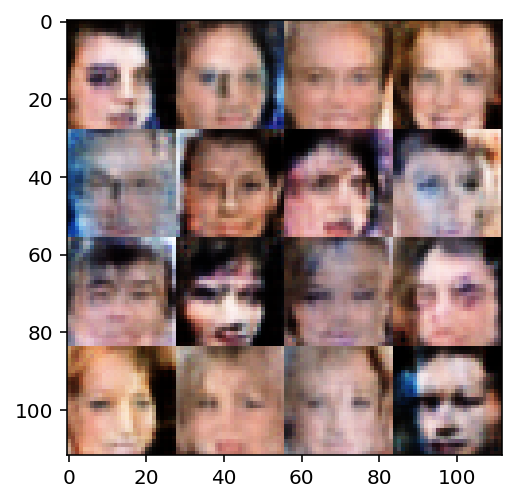

Epoch 1/1... Discriminator Loss: 0.5937... Generator Loss: 2.4688
Epoch 1/1... Discriminator Loss: 0.2976... Generator Loss: 2.1098
Epoch 1/1... Discriminator Loss: 1.4801... Generator Loss: 2.0718
Epoch 1/1... Discriminator Loss: 0.8697... Generator Loss: 0.7747
Epoch 1/1... Discriminator Loss: 1.6471... Generator Loss: 2.4541
Epoch 1/1... Discriminator Loss: 1.1777... Generator Loss: 0.6278
Epoch 1/1... Discriminator Loss: 0.9785... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 1.1440... Generator Loss: 0.4880
Epoch 1/1... Discriminator Loss: 1.1384... Generator Loss: 0.6745
Epoch 1/1... Discriminator Loss: 0.4301... Generator Loss: 1.9715


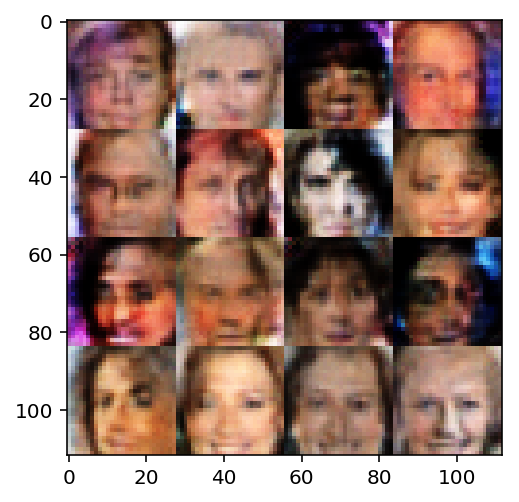

Epoch 1/1... Discriminator Loss: 0.7398... Generator Loss: 1.0345
Epoch 1/1... Discriminator Loss: 1.1478... Generator Loss: 1.5223
Epoch 1/1... Discriminator Loss: 1.0354... Generator Loss: 0.6693
Epoch 1/1... Discriminator Loss: 1.5182... Generator Loss: 2.8012
Epoch 1/1... Discriminator Loss: 0.5303... Generator Loss: 1.5728
Epoch 1/1... Discriminator Loss: 1.1604... Generator Loss: 0.8859
Epoch 1/1... Discriminator Loss: 0.9687... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 0.3177... Generator Loss: 2.6084
Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 1.3149
Epoch 1/1... Discriminator Loss: 0.8350... Generator Loss: 0.8997


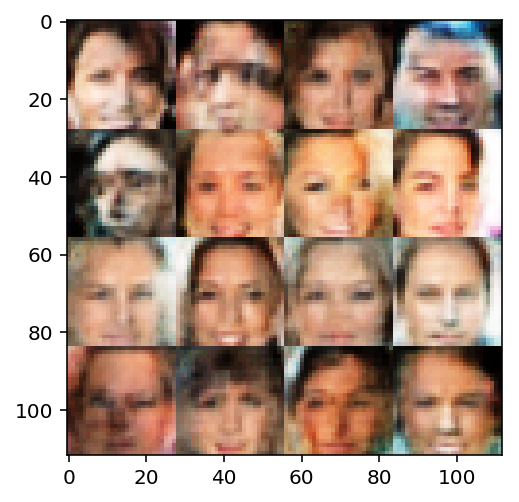

Epoch 1/1... Discriminator Loss: 3.1714... Generator Loss: 4.1550
Epoch 1/1... Discriminator Loss: 0.9918... Generator Loss: 4.6372
Epoch 1/1... Discriminator Loss: 0.4063... Generator Loss: 1.4347
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 2.3628
Epoch 1/1... Discriminator Loss: 0.5132... Generator Loss: 2.2170
Epoch 1/1... Discriminator Loss: 1.0371... Generator Loss: 0.6058
Epoch 1/1... Discriminator Loss: 0.6898... Generator Loss: 1.0580
Epoch 1/1... Discriminator Loss: 0.5879... Generator Loss: 1.1261
Epoch 1/1... Discriminator Loss: 1.6169... Generator Loss: 0.5239
Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 0.8532


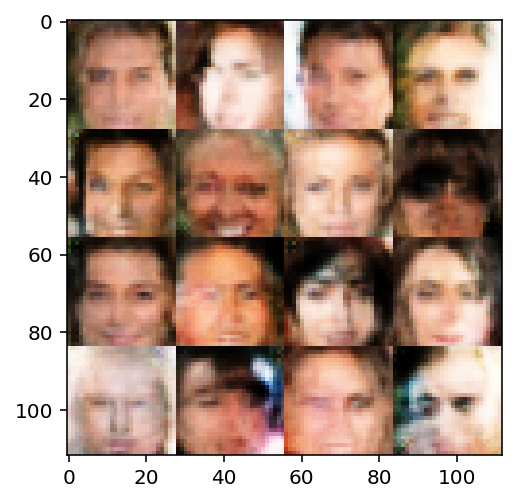

Epoch 1/1... Discriminator Loss: 0.5577... Generator Loss: 1.5034
Epoch 1/1... Discriminator Loss: 0.7819... Generator Loss: 1.5945
Epoch 1/1... Discriminator Loss: 1.1692... Generator Loss: 0.4960
Epoch 1/1... Discriminator Loss: 0.5587... Generator Loss: 1.2179
Epoch 1/1... Discriminator Loss: 0.4455... Generator Loss: 1.4101
Epoch 1/1... Discriminator Loss: 0.9272... Generator Loss: 1.7151
Epoch 1/1... Discriminator Loss: 0.4110... Generator Loss: 2.1326
Epoch 1/1... Discriminator Loss: 0.7299... Generator Loss: 1.1582
Epoch 1/1... Discriminator Loss: 0.9058... Generator Loss: 1.5834
Epoch 1/1... Discriminator Loss: 1.7203... Generator Loss: 0.2747


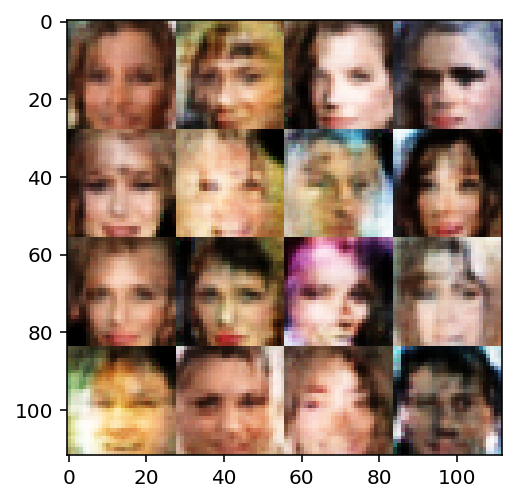

Epoch 1/1... Discriminator Loss: 0.8987... Generator Loss: 1.2116
Epoch 1/1... Discriminator Loss: 0.8197... Generator Loss: 1.5846
Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 0.4700
Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 0.9271... Generator Loss: 1.3817
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.4384
Epoch 1/1... Discriminator Loss: 0.5987... Generator Loss: 2.7981
Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 0.6573
Epoch 1/1... Discriminator Loss: 1.0100... Generator Loss: 0.9234
Epoch 1/1... Discriminator Loss: 1.1421... Generator Loss: 0.5127


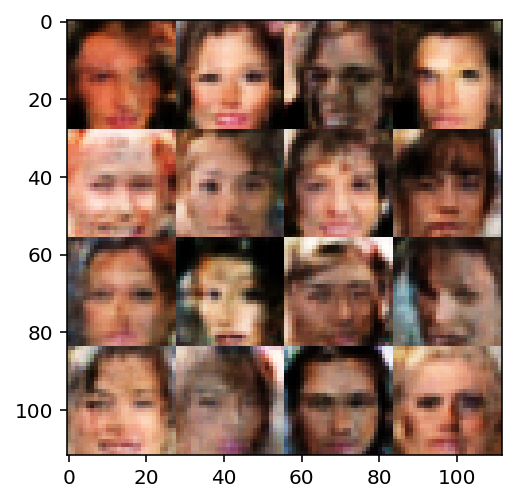

Epoch 1/1... Discriminator Loss: 0.7880... Generator Loss: 2.8853
Epoch 1/1... Discriminator Loss: 0.4647... Generator Loss: 1.5078
Epoch 1/1... Discriminator Loss: 1.0111... Generator Loss: 1.0300
Epoch 1/1... Discriminator Loss: 1.2194... Generator Loss: 0.8883
Epoch 1/1... Discriminator Loss: 0.9236... Generator Loss: 0.9416
Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 0.5957... Generator Loss: 2.2863
Epoch 1/1... Discriminator Loss: 0.6534... Generator Loss: 2.3136
Epoch 1/1... Discriminator Loss: 1.5207... Generator Loss: 0.3753
Epoch 1/1... Discriminator Loss: 1.7308... Generator Loss: 1.8030


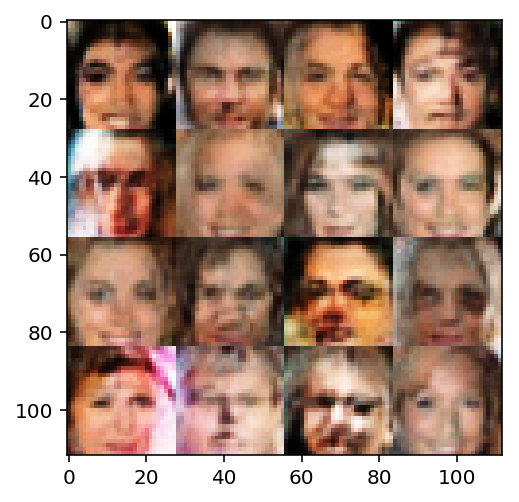

Epoch 1/1... Discriminator Loss: 0.9730... Generator Loss: 2.7473
Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 1.5668
Epoch 1/1... Discriminator Loss: 0.3899... Generator Loss: 1.5400
Epoch 1/1... Discriminator Loss: 1.0807... Generator Loss: 0.9813
Epoch 1/1... Discriminator Loss: 0.5057... Generator Loss: 1.8461
Epoch 1/1... Discriminator Loss: 0.8406... Generator Loss: 1.1423


In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.